In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from glob import glob
from tqdm import tqdm

/tmp/ipykernel_23012/2590474423.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def split_into_files(lines, num_files):
    # Calculate the number of lines per file
    lines_per_file = len(lines) // num_files
    remainder = len(lines) % num_files
    
    # Split lines into chunks for each file
    chunks = []
    start = 0
    for i in range(num_files):
        # Allocate the remainder evenly
        end = start + lines_per_file + (1 if i < remainder else 0)
        chunks.append(lines[start:end])
        start = end
    
    # Write each chunk to a separate file
    for i, chunk in enumerate(chunks):
        with open(f'sh{i+1}.sh', 'w') as f:
            f.write('\n'.join(chunk))

In [3]:
num_epoch = 2500
num_epoch_pretrain = 500
num_trials = 10
view_list = "1,2,3"
lr_e_pretrain = 1e-3
lr_e = 5e-4
lr_c = 1e-3
save_path = "results"

In [4]:
commands = []
count = 0
for view_list in ["1", "2", "3", "1,2", "1,3", "2,3", "1,2,3"]:
    for data_folder in ["BRCA", "ROSMAP", "KIPAN", "LGG"]:
        command = f"python main_uncertainty.py --view_list={view_list} --data_folder={data_folder} --num_trials={num_trials}" \
                  f" --save_path={save_path} --num_epoch={num_epoch}  --num_epoch_pretrain={num_epoch_pretrain}" \
                  f" --lr_e={lr_e} --lr_c={lr_c}"
        print(command)
        count += 1
        commands.append(command)
print(count)

split_into_files(commands, 1)

python main_uncertainty.py --view_list=1 --data_folder=BRCA --num_trials=10 --save_path=results --num_epoch=2500  --num_epoch_pretrain=500 --lr_e=0.0005 --lr_c=0.001
python main_uncertainty.py --view_list=1 --data_folder=ROSMAP --num_trials=10 --save_path=results --num_epoch=2500  --num_epoch_pretrain=500 --lr_e=0.0005 --lr_c=0.001
python main_uncertainty.py --view_list=1 --data_folder=KIPAN --num_trials=10 --save_path=results --num_epoch=2500  --num_epoch_pretrain=500 --lr_e=0.0005 --lr_c=0.001
python main_uncertainty.py --view_list=1 --data_folder=LGG --num_trials=10 --save_path=results --num_epoch=2500  --num_epoch_pretrain=500 --lr_e=0.0005 --lr_c=0.001
python main_uncertainty.py --view_list=2 --data_folder=BRCA --num_trials=10 --save_path=results --num_epoch=2500  --num_epoch_pretrain=500 --lr_e=0.0005 --lr_c=0.001
python main_uncertainty.py --view_list=2 --data_folder=ROSMAP --num_trials=10 --save_path=results --num_epoch=2500  --num_epoch_pretrain=500 --lr_e=0.0005 --lr_c=0.001


# Determine base modalities

In [5]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score


df_performance = pd.DataFrame(columns=['data_folder', 'view_list','acc','measure1','measure2','uncertainty'])
for data_folder in ["BRCA", "ROSMAP", "LGG", "KIPAN"]:
    for view_list in ["1", "2", "3", "1,2", "1,3", "2,3", "1,2,3"]:
        df = pd.read_csv(f"{save_path}/{data_folder}/{view_list}/n_trials{num_trials}.csv")
        pred = df['pred'].to_numpy()
        label = df['label'].to_numpy()
        uncertainty = np.mean(df['std'].to_numpy())
        if data_folder in ['ROSMAP', 'LGG']:
            acc = accuracy_score(label, pred)
            measure1 = f1_score(label, pred)
            measure2 = roc_auc_score(label, pred)
        
        if data_folder in ['BRCA', 'KIPAN']:
            acc = accuracy_score(label, pred)
            measure1 = f1_score(label, pred, average='weighted')
            measure2 = f1_score(label, pred, average='macro')

        df_performance.loc[df_performance.shape[0]] = pd.Series({"data_folder": data_folder, "view_list": view_list.replace(",","-"), 
                                                                 "acc": acc, "measure1": measure1, "measure2": measure2, "uncertainty": uncertainty})
df_performance.head(5)
df_performance.to_csv(f"{save_path}/performance.csv", index=False)

In [6]:
# select the modality with highest accuracy

result_df = pd.DataFrame(columns=["data_folder", "view_list", "acc", "measure1", "measure2", "uncertainty"])
for dataset in ["BRCA", "ROSMAP", "LGG", "KIPAN"]:
    df_performance_sub = df_performance[df_performance['data_folder']==dataset]
    single_modality_df = df_performance_sub[df_performance_sub['view_list'].apply(lambda x: '-' not in x)]
    best_single_modality = single_modality_df.loc[single_modality_df['acc'].idxmax()]

    # Step 2: Select the best two-modality view containing the best single modality
    best_single_view = best_single_modality['view_list']
    two_modality_df = df_performance_sub[df_performance_sub['view_list'].apply(lambda x: '-' in x and len(x.split('-')) == 2 and best_single_view in x)]
    best_two_modality = two_modality_df.loc[two_modality_df['acc'].idxmax()]

    # Step 3: Keep the row with the view list of 1-2-3 if it exists
    three_modality_df = df_performance_sub[df_performance_sub['view_list'] == '1-2-3']

    # Combine all selected rows into a new dataframe
    result_df_sub = pd.concat([best_single_modality.to_frame().T, best_two_modality.to_frame().T, three_modality_df])
    result_df = pd.concat([result_df_sub, result_df])

result_df.to_csv(f"{save_path}/result_df.csv", index=False)
result_df

,data_folder,view_list,acc,measure1,measure2,uncertainty
22,KIPAN,2,0.979798,0.979777,0.984897,0.017143
24,KIPAN,1-2,0.984848,0.984841,0.988684,0.017673
27,KIPAN,1-2-3,0.994949,0.994952,0.996235,0.016684
14,LGG,1,0.836601,0.832215,0.838351,0.027615
17,LGG,1-2,0.843137,0.84,0.84468,0.087706
20,LGG,1-2-3,0.830065,0.831169,0.830739,0.176923
7,ROSMAP,1,0.801887,0.807339,0.801961,0.078116
10,ROSMAP,1-2,0.839623,0.834951,0.841889,0.09799
13,ROSMAP,1-2-3,0.858491,0.857143,0.860071,0.158837
0,BRCA,1,0.828897,0.806591,0.777402,0.054242


# Visualize Uncertainty

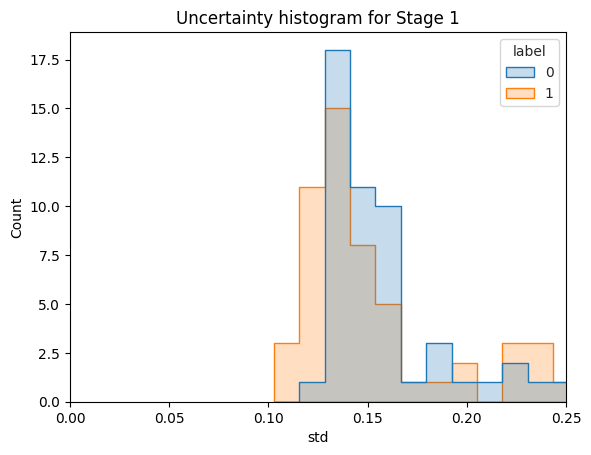

In [7]:
data_folder = "ROSMAP"
view_list = "1,2,3"
df = pd.read_csv(f"{save_path}/{data_folder}/{view_list}/n_trials{num_trials}.csv")
#df
fig, ax = plt.subplots()
sns.set_style("whitegrid")
sns.histplot(df, x="std", hue="label", ax=ax, palette="tab10", element="step")
ax.set_title("Uncertainty histogram for Stage 1")
ax.set_xlim(0,0.25)
plt.show()

# Set thresh

In [19]:
df_staged = pd.DataFrame(columns=["data_folder", "acc", "measure1", "measure2", "t1", "t2"])

for data_folder in ["ROSMAP", "BRCA", "LGG", "KIPAN"]:
    view_lists = result_df[result_df['data_folder']==data_folder]['view_list'].to_list()
    converted_view_list = [view.replace('-', ',') for view in view_lists]

    df_uni = pd.read_csv(f"{save_path}/{data_folder}/{converted_view_list[0]}/n_trials{num_trials}.csv").copy()
    df_bi = pd.read_csv(f"{save_path}/{data_folder}/{converted_view_list[1]}/n_trials{num_trials}.csv").copy()
    df_tri = pd.read_csv(f"{save_path}/{data_folder}/{converted_view_list[2]}/n_trials{num_trials}.csv").copy()
    threshold_range_uni = np.linspace(df_uni['std'].min(), df_uni['std'].max(), 100)
    threshold_range_bi = np.linspace(df_bi['std'].min(), df_bi['std'].max(), 100)

    best_accuracy = 0.
    best_threshold_t1 = 0
    best_threshold_t2 = 0

    for t1 in tqdm(threshold_range_uni):
        for t2 in threshold_range_bi:
            df_classified_confident_stage = pd.DataFrame(columns=["patient_id", "stage", "std", "pred", "label"])
            move_forward = True

            # single view
            df_uni['confident'] = df_uni['std'] <= t1
            df_uni_confident = df_uni[df_uni['confident']]
            df_uni_confident = df_uni_confident.copy()
            df_uni_confident.loc[:, "stage"] = view_lists[0]

            df_uni_confident = df_uni_confident[["patient_id", "stage", "std", "pred", "label"]]
            df_classified_confident_stage = pd.concat([df_classified_confident_stage, df_uni_confident], ignore_index=True)

            if df_classified_confident_stage.shape[0] != df_uni.shape[0]:
                # Unconfident predictions - use 2 views
                df_uni_unconfident = df_uni[~df_uni['confident']]
                df_bi_sub = df_bi[df_bi['patient_id'].isin(df_uni_unconfident['patient_id'])]
                df_bi_sub = df_bi_sub.copy()
                df_bi_sub.loc[:, 'confident'] = df_bi_sub['std'] <= t2
                df_bi_confident = df_bi_sub[df_bi_sub['confident']]
                
                if df_bi_confident.shape[0] == 0:
                    # t2 is too small, no subjects in bi-view model is confident
                    continue
                
                df_bi_confident = df_bi_confident.copy()
                df_bi_confident.loc[:, "stage"] = view_lists[1]
                df_bi_confident = df_bi_confident[["patient_id", "stage", "std", "pred", "label"]]
                df_classified_confident_stage = pd.concat([df_classified_confident_stage, df_bi_confident], ignore_index=True)

                if df_classified_confident_stage.shape[0] != df_uni.shape[0]:
                    # Unconfident predictions - use 3 views
                    df_bi_unconfident = df_bi_sub[~df_bi_sub['confident']]
                    df_tri_sub = df_tri[df_tri['patient_id'].isin(df_bi_unconfident['patient_id'])]
                    df_tri_sub = df_tri_sub.copy()
                    df_tri_sub.loc[:, 'stage'] = view_lists[2]
                    df_tri_sub = df_tri_sub[["patient_id", "stage", "std", "pred", "label"]]
                    df_classified_confident_stage = pd.concat([df_classified_confident_stage, df_tri_sub], ignore_index=True)

            assert df_classified_confident_stage.shape[0] == df_uni.shape[0]
            total_accuracy = accuracy_score(df_classified_confident_stage['label'].to_list(), df_classified_confident_stage['pred'].to_list())
            
            # Update best threshold if this one is better
            if total_accuracy > best_accuracy:
                best_accuracy = total_accuracy
                best_threshold_t1 = t1
                best_threshold_t2 = t2
                df_classified_confident_stage.to_csv(f"{save_path}/{data_folder}/staged_results.csv", index=False)
            # print(f"acc = {total_accuracy}, t1 = {t1}, t2 = {t2}")

    if data_folder in ["ROSMAP", "LGG"]:
        measure1 = f1_score(df_classified_confident_stage['label'].to_list(), df_classified_confident_stage['pred'].to_list())
        measure2 = roc_auc_score(df_classified_confident_stage['label'].to_list(), df_classified_confident_stage['pred'].to_list())
    elif data_folder in ["KIPAN", "BRCA"]:
        measure1 = f1_score(df_classified_confident_stage['label'].to_list(), df_classified_confident_stage['pred'].to_list(), average='weighted')
        measure2 = f1_score(df_classified_confident_stage['label'].to_list(), df_classified_confident_stage['pred'].to_list(), average='macro')
    print(f"data_folder = {data_folder}, best_accuracy = {best_accuracy}, measure1 = {measure1}, measure2 = {measure2}, best_threshold_t1 = {best_threshold_t1}, best_threshold_t2 = {best_threshold_t2}")
    df_staged.loc[df_staged.shape[0]] = pd.Series({"data_folder": data_folder, "acc": best_accuracy, "measure1": measure1, "measure2": measure2, 
                                                    "t1": best_threshold_t1, "t2": best_threshold_t2})
df_staged.to_csv(f"{save_path}/staged_performance.csv", index=False)

100%|██████████| 100/100 [00:18<00:00,  5.33it/s]


data_folder = ROSMAP, best_accuracy = 0.8773584905660378, measure1 = 0.8073394495412844, measure2 = 0.8019607843137255, best_threshold_t1 = 0.052730848484848485, best_threshold_t2 = 0.10244130702020204


100%|██████████| 100/100 [00:21<00:00,  4.62it/s]


data_folder = BRCA, best_accuracy = 0.8783269961977186, measure1 = 0.8065905822562395, measure2 = 0.7774021918595325, best_threshold_t1 = 0.015847373737373736, best_threshold_t2 = 0.09898550187878788


100%|██████████| 100/100 [00:16<00:00,  6.04it/s]


data_folder = LGG, best_accuracy = 0.8627450980392157, measure1 = 0.8322147651006712, measure2 = 0.8383510092370852, best_threshold_t1 = 0.0, best_threshold_t2 = 0.050267941555555556


100%|██████████| 100/100 [00:19<00:00,  5.09it/s]

data_folder = KIPAN, best_accuracy = 1.0, measure1 = 0.9797774100943248, measure2 = 0.9848966950914259, best_threshold_t1 = 0.0, best_threshold_t2 = 0.10031043024444443


# Count percentage of each view

In [30]:
df_staged_percent = pd.DataFrame(columns=["data_folder", "stage1", "stage2", "stage3"])
for data_folder in ["ROSMAP", "BRCA", "LGG", "KIPAN"]:
    df_classified_confident_stage = pd.read_csv(f"{save_path}/{data_folder}/staged_results.csv")
    n_subjects = df_classified_confident_stage.shape[0]
    stages = pd.unique(df_classified_confident_stage['stage'])
    stage_strings = []
    for stage in stages:
        stage_string = ""
        if stage.rfind("1")!=-1:
            stage_string += "mRNA|"
        if stage.rfind("2")!=-1:
            stage_string += "methy|"
        if stage.rfind("3")!=-1:
            stage_string += "miRNA|"
        stage_string += f"{df_classified_confident_stage[df_classified_confident_stage['stage']==stage].shape[0]/n_subjects *100 : 0.2f}%"
        stage_strings.append(stage_string)
    df_staged_percent.loc[df_staged_percent.shape[0]] = pd.Series({"data_folder": data_folder, "stage1": stage_strings[0] , "stage2": stage_strings[1] , "stage3": stage_strings[2]})

df_staged_percent


,data_folder,stage1,stage2,stage3
0,ROSMAP,mRNA| 46.23%,mRNA|methy| 16.04%,mRNA|methy|miRNA| 37.74%
1,BRCA,mRNA| 53.61%,mRNA|methy| 33.84%,mRNA|methy|miRNA| 12.55%
2,LGG,mRNA| 14.38%,mRNA|methy| 7.19%,mRNA|methy|miRNA| 78.43%
3,KIPAN,methy| 2.02%,mRNA|methy| 91.41%,mRNA|methy|miRNA| 6.57%


# Visualize uncertainty distribution

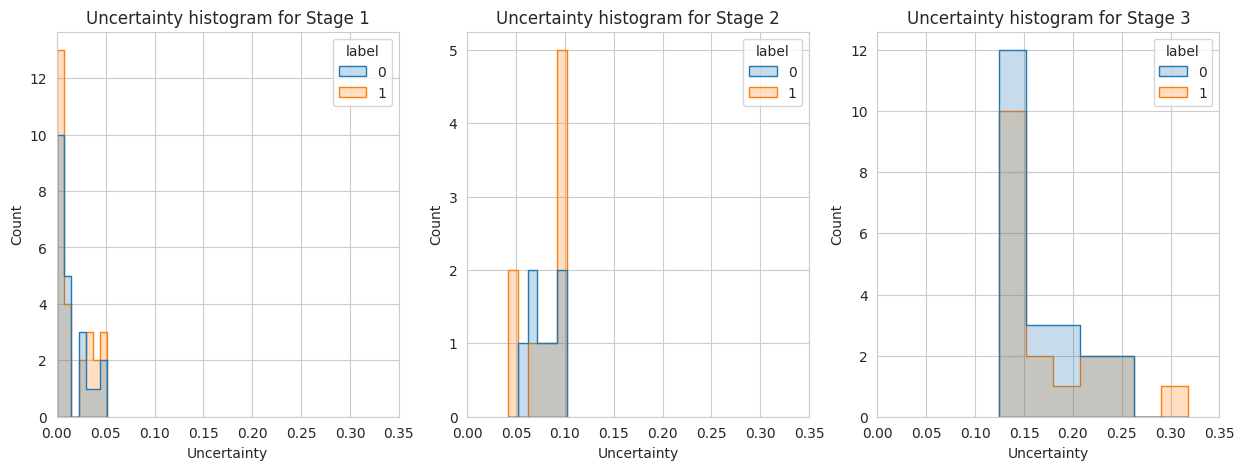

In [51]:
data_folder = "ROSMAP"
view_lists = result_df[result_df['data_folder']==data_folder]['view_list'].to_list()
converted_view_list = [view.replace('-', ',') for view in view_lists]

df_classified_confident_stage = pd.read_csv(f"{save_path}/{data_folder}/staged_results.csv")

fig, axes = plt.subplots(1, 3)
fig.set_figwidth(15)
fig.set_figheight(5)
sns.set_style("whitegrid")
for i in range(3):
    df_classified_confident_stage_sub = df_classified_confident_stage[df_classified_confident_stage['stage']==view_lists[i]]
    sns.histplot(df_classified_confident_stage_sub, x="std", hue="label", ax=axes[i], palette="tab10", element="step")
    axes[i].set_title(f"Uncertainty histogram for Stage {i+1}")
    axes[i].set_xlim(0,0.35)
    axes[i].set_xlabel("Uncertainty")
plt.show()

In [48]:
view_lists

['1', '1-2', '1-2-3']